In [1]:
import numpy as np
from matplotlib import pylab as plt
%matplotlib inline
plt.rcParams['text.usetex'] = True
import scipy
from scipy import integrate as sciint
from scipy import optimize as sciopt
import numba as nb
import pickle
import funcs


In [3]:
c=2.9792458e10#cm s-1
mev2erg = 1.0218e-6
mpc2 = 938.72*mev2erg # erg
pi = np.pi
day2sec=5184000

In [3]:
n0=1e-3#cm-3
n0c3 = n0 * c**3 #s^-3

Gshmax = 100

In [4]:
theta_c = 0.3 #rad
theta_G = 0.059 #rad
E_g = 1.16e52 #erg
def gaussian_profile(theta, theta_G, theta_c, E_g):
    res = np.zeros_like(theta)
    res[theta<=theta_c] = E_g * np.exp(-0.5*(theta/theta_G)**2)
    return res

In [5]:
theta_v = 0.25
def mu(theta, theta_v, phi):
    return np.cos(theta)*np.cos(theta_v) + np.sin(theta)*np.sin(theta_v)*np.cos(phi)

In [6]:
nphi=50
ntheta=100
phi = np.linspace(0,2*pi,nphi) #rad
theta = np.linspace(0, theta_c, ntheta) #rad
phis, thetas = np.meshgrid(phi, theta)
mus = mu(thetas, theta_v, phis)
Es = gaussian_profile(theta, theta_G, theta_c, E_g)
xs = Es / n0 #scaling relation

In [7]:
T = 10*day2sec
t_emiss = funcs._emission_times(T, xs, Gshmax, mus)

In [8]:
t_emiss/day2sec

array([[5.09138037, 5.09138037, 5.09138037, ..., 5.09138037, 5.09138037,
        5.09138037],
       [5.08945881, 5.08947467, 5.089522  , ..., 5.089522  , 5.08947467,
        5.08945881],
       [5.08756163, 5.08759333, 5.08768793, ..., 5.08768793, 5.08759333,
        5.08756163],
       ...,
       [5.01485198, 5.01632504, 5.02072515, ..., 5.02072515, 5.01632504,
        5.01485198],
       [5.01519657, 5.01668457, 5.02112939, ..., 5.02112939, 5.01668457,
        5.01519657],
       [5.01556417, 5.01706712, 5.02155666, ..., 5.02155666, 5.01706712,
        5.01556417]])

In [ ]:
zetas = funcs._find_zeta(Gsh)

In [4]:
E=10**50 #ergs
t=10**8  #sec
n=1e-3  #cm-3
U1 = E*t**(-3)/n/mpc2/c**3
U2 = 1e50 *1e-24*1.e3/mpc2/c**3 * (E/1e50) * (t/1e8)**(-3) * (n/1.e-3)**(-1)
E=1
t=1
n=1
U3=1e50 *1e-24*1.e3/mpc2/c**3 * E * t**(-3) * n**(-1)
U1,U2,U3

(3.94256646445544, 3.94256646445544, 3.94256646445544)

0.9611903844082083 0.9622916067054939
921 µs ± 11.2 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


Text(0, 0.5, '$\\beta_{sh}$')

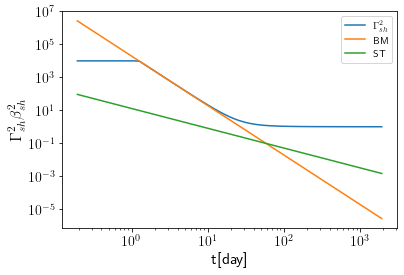

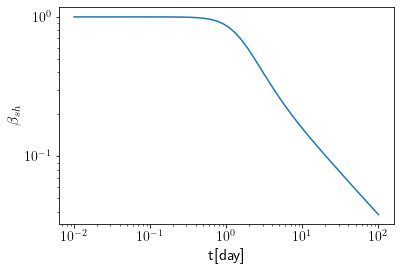

In [7]:
u = 1e50 *1e-24*1.e3/mpc2/c**3
bm = 17/8/pi
st = (2*1.15/5)**2
x = E / n #scaling relation

def U(t, x):# t, E, n in units of 1e8 s, 1e50 ergs, 1e-3 cm-3
    return u * x * t**(-3)
#simple connexion of BM and ST solution, with a capping max Gamma_shell
def BM(t, x):
    return bm*U(t, x)
def ST(t, x):
    return st*U(t, x)**(2/5)
def A(t, x):
    return BM(t, x) + ST(t, x)
def GB2(t, x, Gshmax) :
    val = A(t, x)
    if np.isscalar(val):
        return min(val, Gshmax)
    val[val>=Gshmax**2]=Gshmax**2
    return val

def G2(t, x, Gshmax):
    return GB2(t, x, Gshmax)+1

def B2(t, x, Gshmax):
    return GB2(t,x, Gshmax) / (GB2(t, x, Gshmax)+1)
    
def R(t, x, Gshmax):
    def B(t, x, Gsmax): return np.sqrt(B2(t, x, Gshmax))
    res = sciint.quad(B,0,t,args=(x, Gshmax))
    return res[0]

def RR(t,x,Gshmax):
    uarr = np.logspace(-5,np.log10(t),1000)
    barr = np.sqrt(B2(uarr,x, Gshmax))
    mid = (barr[1:]+barr[:-1])/2
    res = mid*np.diff(uarr)
    return res.sum()

print(R(1,x,Gshmax), RR(1,x, Gshmax))
%timeit R(1,x,Gshmax)
#%timeit RR(1,x,Gshmax)

tarr = np.logspace(-2,2,50)
E=1
n=1
plt.loglog(tarr*1.e8/day2sec, G2(tarr, x, Gshmax), label=r'$\Gamma_{sh}^2$')
plt.loglog(tarr*1.e8/day2sec, BM(tarr, x), label='BM')
plt.loglog(tarr*1.e8/day2sec, ST(tarr, x), label='ST')
plt.xlabel("t[day]", fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.ylabel(r'$\Gamma_{sh}^2\beta_{sh}^2$', fontsize=16)
plt.legend()

plt.subplots()
plt.loglog(tarr, np.sqrt(B2(tarr, x, Gshmax)))
plt.xlabel("t[day]", fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.ylabel(r'$\beta_{sh}$', fontsize=16);


In [8]:
import funcs
%timeit funcs._R(1,x,Gshmax)
#%timeit funcs._RR(1,x,Gshmax)

537 µs ± 12.9 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


The sequence is as follows :

1/ sample the integration variables
- phi_j uniform between 0 and 2pi
- theta_i and E_i=E(theta_i) sampled depending on the jet structure model, typically theta_i uniform between 0 and a jet cutoff
- compute mu_ij given also the fixed parameter theta_V

2/ find the shock dynamics variables:
- compute t_ij via root finding (tij=T+mu_ij R(t_ij)/c)
- this also yiels Rij, bsh_ij and gsh_ij at t_ij

3/ find the electron population variables: Gamma_ij, gamma_ij, etc...

4/ build the functional of the integral

5/ inetgrate by summation

6/ iterate the whole procedure over T

## Integration variables, and related variables

## Shock dynamics



In [7]:
def CBM(E):
    return np.sqrt(E/8/pi/mpc2/n0c3)
def CST(E):
    return 2*1.15/5 * (E/mpc2/n0c3)**(1/5)

In [153]:
def A(t,n0, E, Gshmax):
    if np.isscalar(E): E=np.array([E,])
    val = CBM(E)**2*t**(-3) + CST(E)**2 * t**(-6/5)
    val[val>=Gshmax**2]=Gshmax**2
    return val

#@nb.jit(nopython=True)
def bsh(t, n0, E, Gshmax):
    a = A(t,n0, E, Gshmax)
    return np.sqrt(a/(1+a))

def gsh(t, n0, E, Gshmax):
    return np.sqrt(1/(1-bsh(t, n0, E, Gshmax)**2))

#@nb.jit(nopython=True)
def R(t, n0, E, Gshmax):
    res = sciint.quad(bsh,0,t,args=(n0, E, Gshmax))
    return res[0]

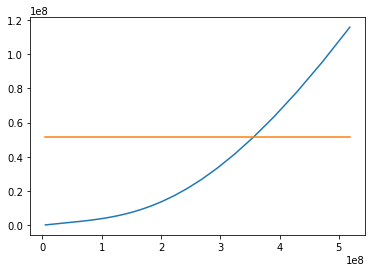

In [99]:
T = 10*day2sec
#ts=np.logspace(np.log10(0.1*T), np.log10(10*T))
#TT=np.zeros_like(ts)
#for i,t in enumerate(ts):
#    TT[i] = t-mus[1,4]*R(t, n0, Es[1], Gshmax)
#plt.plot(ts,TT)
#plt.plot(ts, T*np.ones_like(ts))

##@nb.jit(nopython=True)
def func(t, n0, E, Gshmax, mu):
    return t - T - mu * R(t, n0, E, Gshmax)
#@nb.jit(nopython=False)
def func_deriv(t, n0, E, Gshmax, mu):
    return 1 - mu * bsh(t, n0, E, Gshmax)

#@nb.jit(nopython=False)
def emission_times(T,n0, Es, Gshmax, mus):
    ts = np.zeros_like(mus)
#    tmp = T
    for i in range(mus.shape[0]):
        for j in range(mus.shape[1]):
#    for i in range(2):
#        for j in range(10):
#            print(i,j,Es[i],mus[i,j])
#            ts[i,j] = sciopt.bisect(func, a=T, b=10*T, args=(n0, Es[i], Gshmax, mus[i,j])).real
#            ts[i,j] = sciopt.newton(func, x0=T, fprime=func_deriv, args=(n0, Es[i], Gshmax, mus[i,j]), maxiter=100).real
            ts[i,j] = sciopt.root_scalar(func, x0=T, fprime=func_deriv, method='newton',\
                                         args=(n0, Es[i], Gshmax, mus[i,j]), maxiter=50).root[0]
#            ts[i,j] = sciopt.root_scalar(func, bracket=(T,10*T), method='bisect',\
#                                         args=(n0, Es[i], Gshmax, mus[i,j]), maxiter=50).root
#            tmp=ts[i,j]
    return ts

emiss_t = emission_times(T,n0, Es, Gshmax, mus)

In [105]:
#with open('emiss_t.pkl','wb') as f:
#    pickle.dump(emiss_t, f)
with open('emiss_t.pkl','rb') as f:
    emiss_t = pickle.load(f)

In [154]:
emiss_t.min(), emiss_t.max()

(69395157.99508911, 357823949.6878983)

In [151]:
gammas_sh = np.zeros_like(emiss_t)
for j in range(nphi):
    gammas_sh[:,j] = gsh(emiss_t[:,j], n0, Es, Gshmax)

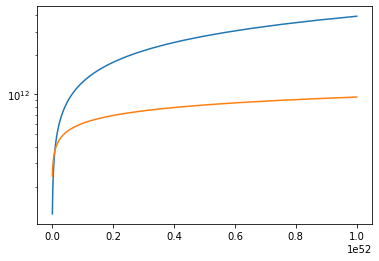

In [21]:
energies = np.logspace(49,52)
plt.semilogy(energies, CBM(energies))
plt.semilogy(energies, CST(energies)*1.e7)

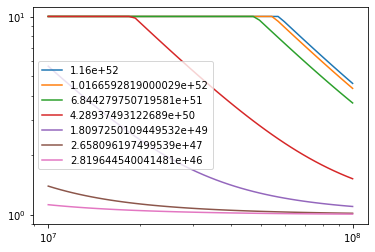

In [157]:
times = np.logspace(7,8)
for i in [0,10,20,50, 70,90,99]:
    y = gsh(times, n0, Es[i], Gshmax)
#    plt.loglog(times,1/(1-Bsh**2), label=Es[i])
    plt.loglog(times, y, label=Es[i])
plt.legend()

Text(0.5, 1.0, 'R(t)')

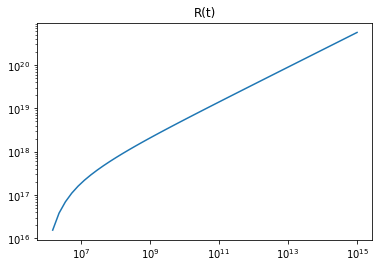

In [117]:
dt = np.diff(times)
mid_b = (Bsh[1:]+Bsh[:-1])/2
R = np.cumsum(mid_b*dt)*c
plt.loglog(times[1:], R)
plt.title ('R(t)')

## Electron population

In [121]:
from scipy import optimize as sciopt
from scipy.special import kn

def G(x):
    return kn(3, x)/kn(2,x)-1/x

def g(x):
    return 1 + 4*kn(2,x) / x / (3*kn(3,x)+kn(1,x)-4*kn(2,x))

def n_prime(x) :
    return n0 * (g(x) * G(x) + 1) / (g(x)-1)

def rootfunc(x,Gsh):
    Gamma = G(x)
    gamma = g(x)
    return (Gamma+1)*(1+gamma*(Gamma-1))**2 / (2+gamma*(2-gamma)*(Gamma-1)) - Gsh**2


In [152]:
gammas_sh.min(), gammas_sh.max()

(1.0100964050021284, 1.3902066270681406)

1.386633072921673 7.505231695879304


/tmp/ipykernel_751298/2358074863.py:5: RuntimeWarning: invalid value encountered in double_scalars
  return kn(3, x)/kn(2,x)-1/x
/tmp/ipykernel_751298/2358074863.py:8: RuntimeWarning: invalid value encountered in double_scalars
  return 1 + 4*kn(2,x) / x / (3*kn(3,x)+kn(1,x)-4*kn(2,x))


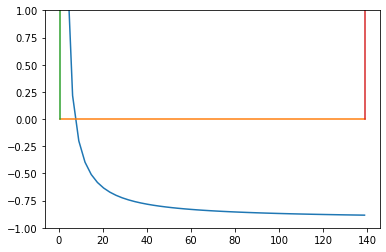

In [149]:

Gsh=gammas_sh[0,40]
x=np.linspace(1./Gsh,100*Gsh)
plt.plot(x,rootfunc(x,Gsh))
plt.plot(x,np.zeros_like(x))
plt.plot([1/Gsh, 1/Gsh],[0,10])
plt.plot([100*Gsh, 100*Gsh],[0,10])
plt.ylim(-1,1)
zetas = sciopt.bisect(rootfunc,args=Gsh, a=1/Gsh, b=1000*Gsh).real
print(Gsh,res)


In [114]:
Gamma = G(res)
gamma = g(res)
nprime = n0 * (gamma*Gamma + 1) / (gamma - 1)
eprime = mpc2 * nprime * (Gamma-1)

In [125]:
beta = np.sqrt(1 - 1/Gamma**2)
bu = Bsh
bd = (Bsh-beta)/(1-beta*Bsh)
e_index = (3*bu - 2*bu*bd**2 + bd**3) / (bu - bd) - 2

In [126]:
g_prime_m = np.max(1, (e_index-1)/(e_index+1)*mp/me*eps_e*(Gamma-1))
n_prime_R = n_prime * np.min(1, p-2/p-1*mp/me/eps_e*(Gamma-1))
g_prime_c = 3*mec*Gamma / (4*sigmaT*eps_b*eprime*t)


array([9.95037190e-01, 9.95037190e-01, 9.95037190e-01, 9.95037190e-01,
       9.95037190e-01, 9.95037190e-01, 9.95037190e-01, 9.95037190e-01,
       9.95037190e-01, 9.95037190e-01, 9.90348096e-01, 9.69241946e-01,
       9.13714472e-01, 8.04914789e-01, 6.59379592e-01, 5.18609987e-01,
       4.03712819e-01, 3.14408899e-01, 2.45113985e-01, 1.91056246e-01,
       1.48789505e-01, 1.15757605e-01, 8.99824945e-02, 6.99022739e-02,
       5.42791898e-02, 4.21355080e-02, 3.27024961e-02, 2.53782367e-02,
       1.96928864e-02, 1.52804839e-02, 1.18563881e-02, 9.19941272e-03,
       7.13778006e-03, 5.53813327e-03, 4.29696616e-03, 3.33395267e-03,
       2.58676098e-03, 2.00702505e-03, 1.55721672e-03, 1.20821768e-03,
       9.37435140e-04, 7.27339583e-04, 5.64330064e-04, 4.37853810e-04,
       3.39723092e-04, 2.63585185e-04, 2.04511117e-04, 1.58676584e-04,
       1.23114375e-04, 9.55222807e-05])

In [ ]:
B_prime = np.sqrt(8*pi*eps_b*eprime)
def peak_emissivity(e_index):
    return 0.88*256/27*(e_index-1)/(3*e_index-1)*qe**3/mec2 * n_prime_R * B_prime
nu_prime_m = 3/16 * g_prime_m**2*qe*B_prime/mec
nu_prime_c = 3/16 * g_prime_c**2*qe*B_prime/mec

def emissivity(nu, nu_prime_m, nu_prime_c):
    p = e_index
    res=zeros_like(nu)
    if nu_prime_m < nu_prime_c:
        res[nu<nu_prime_m] = (nu / nu_prime_m)**(1/3)
        res[nu>=nu_prime_c] = (nu_prime_c/nu_prime_m)**(-(p-1)/2) * (nu/nu_prime_c)**(-p/2.)
        res[np.logical_and(nu>=nu_prime_m, nu<nu_prime_c)] = (nu / nu_prime_m)**(-(p-1)/2)
    if nu_prime>=nu_prime_c:
        res[nu<nu_prime_c] = (nu / nu_prime_c)**(1/3)
        res[nu>=nu_prime_m] = (nu_prime_m/nu_prime_c)**(-1/2) * (nu/nu_prime_m)**(-p/2.)
        res[np.logical_and(nu>=nu_prime_c, nu<nu_prime_m)] = (nu/nu_prime_c)**(-1/2)
    return peak_emissivity(p) * res

In [ ]:
from scipy.special import gamma as gfunc

g_prime_min = np.min(g_prime_c, g_prime_m)
nu_prime_min = np.min(nu_prime_c, nu_prime_m)
p_tilde = 2
if g_prime_m < g_prime_c:
    p_tilde = e_index
nu_prime_0 = ( (2**((3*p_tilde+8)/2)*(p_tilde-1)*gfunc(3/2+p_tilde/4)*gfunc(11/6+p_tilde/4)*gfunc(1/6+p_tilde/4)*qe*nprime_R) \
              / ((p_tilde+2*gfunc(2+p_tilde/4)*g_prime_min**5*B_prime)) )**(6/(3*p_tilde+2))

self_abs_coeff = 2**6*pi**(5/6)*(p_tilde+2)*(p_tilde-1)*qe*n_prime_R / \
(15*(3*p_tilde+2)*gfunc(5/6)*g_prime_min**5*B_prime) *(nu_prime_0/nu_prime_min)**(-5/3)

def alpha_prime(nu):
    res=zeros_like(nu)
    res[nu<nu_prime_0] = (nu/nu_prime_0)**(-5/3)
    res[nu>=nu_prime_0] = (nu/nu_prime_0)**(-(p_tilde+4)/2)
    return res * self_abs_coeff
    
def alpha(nu) : return G(x)*(1-b(x)*mu)*alpha_prime(nu)
delta_s = R / (12*G(x)**2*np.abs(mu-bsh))
def tau(nu) : return alpha(nu) * delta_s

In [4]:
T = 10*day2sec
nu = 1e18
n0 = 1.e-3
eps_e = 0.5
eps_b = 0.5
theta_v = 0.25
D_L = 1
Gshmax = 100
theta_G = 0.3
theta_c = 0.059
E_g = 1.16e52

#funcs.synchrotron_flux(T, nu, n0, eps_e, eps_b, theta_v, D_L, Gshmax, theta_G, theta_c, E_g)
funcs._flux_integrand(0.5, 0.5, T, nu, n0, eps_e, eps_b, theta_v, Gshmax, theta_G, theta_c, E_g)

/home/cohen/miniconda3/envs/grb/lib/python3.9/site-packages/scipy-1.9.0-py3.9-linux-x86_64.egg/scipy/optimize/_zeros_py.py:556: RuntimeWarning: invalid value encountered in double_scalars
  r = _zeros._bisect(f, a, b, xtol, rtol, maxiter, args, full_output, disp)
/home/cohen/miniconda3/envs/grb/lib/python3.9/site-packages/scipy-1.9.0-py3.9-linux-x86_64.egg/scipy/optimize/_zeros_py.py:556: RuntimeWarning: divide by zero encountered in double_scalars
  r = _zeros._bisect(f, a, b, xtol, rtol, maxiter, args, full_output, disp)


ValueError: math domain error

Exception ignored in: 'funcs._B_prime'
Traceback (most recent call last):
  File "/tmp/ipykernel_1665650/1969838231.py", line 14, in <cell line: 14>
ValueError: math domain error


ZeroDivisionError: float division

Exception ignored in: 'funcs._emissivity'
Traceback (most recent call last):
  File "/tmp/ipykernel_1665650/1969838231.py", line 14, in <cell line: 14>
ZeroDivisionError: float division


1.5720945334352542e-18 0.0 0.0


ZeroDivisionError: float division